# Overview

- This dataset is about Supply Chain of any retail store. It consists of 8 csv files. The size of dataset is over 2GB. All files have shapes, so I didn't concat or join them. 
- Mainly upload all files and convert their date columns into proper datetime format.
- Because of Big Data, I choose the sample of only goodsale.csv for data analysis. 
- The main agenda is to use Dask as much as possible.

In [2]:
import dask
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import os
import glob
%matplotlib inline

# Full_Date 

This table has only date. We can see from which date to which date is of dataset. Dataset is from 2017-03-01 to 2018-03-16.

### Dask vs Pandas
- We can see 15 ms took pandas to read and 12 ms took dask to read this csv file. Dask is faster than pandas becasue of parallel computing.

In [4]:
%%time
pd_data=pd.read_csv("data/full_date.csv")

Wall time: 15 ms


In [3]:
pd_data.head(5)

,data_date
0,2017.3.1
1,2017.3.2
2,2017.3.3
3,2017.3.4
4,2017.3.5


In [5]:
%%time
full_date=dd.read_csv("data/full_date.csv")

Wall time: 12 ms


In [6]:
full_date["data_date"] = dd.to_datetime(full_date.data_date)

- Changed the date column into datetime format. It consists of 1 year plus 16 days, in total 381 days of data.

In [7]:
full_date.compute()

,data_date
0,2017-03-01
1,2017-03-02
2,2017-03-03
3,2017-03-04
4,2017-03-05
...,...
376,2018-03-12
377,2018-03-13
378,2018-03-14
379,2018-03-15


In [8]:
full_date.compute().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   data_date  381 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 3.1 KB


# Promotion Goods
 It shows the promotion of goods.

In [7]:
%%time
promote_goods=dd.read_csv("data/goods_promote_price.csv", dtype="unicode")

Wall time: 76 ms


In [8]:
promote_goods["data_date"] = dd.to_datetime(promote_goods.data_date)

In [11]:
promote_goods.compute()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time
0,2018-01-29,GBLrYn,289,0,1970.1.1 08:00,1970.1.1 08:00
1,2018-01-29,GfrkEb,17.99,0,1970.1.1 08:00,1970.1.1 08:00
2,2018-01-29,GD8pMl,412,0,1970.1.1 08:00,1970.1.1 08:00
3,2018-01-29,Gfid4P,87,0,1970.1.1 08:00,1970.1.1 08:00
4,2018-01-29,Gzjk0i,43.99,0,1970.1.1 08:00,1970.1.1 08:00
...,...,...,...,...,...,...
1048570,2018-03-07,GhltHS,10.99,0,1970.1.1 08:00,1970.1.1 08:00
1048571,2018-03-07,GGUjIf,16.99,6.99,2017.12.28 10:00,2018.3.28 18:00
1048572,2018-03-07,GS3sLX,191,172,2018.3.1 19:00,2018.3.9 18:00
1048573,2018-03-07,G52r6v,13.99,0,1970.1.1 08:00,1970.1.1 08:00


## Take sample the Promotion goods

In [63]:
%%time
promo_sample=promote_goods.sample(frac=0.05).compute() 

Wall time: 1.72 s


In [64]:
promo_sample.shape

(52429, 6)

In [12]:
promo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31457 entries, 603518 to 888834
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_date           31457 non-null  datetime64[ns]
 1   goods_id            31457 non-null  object        
 2   shop_price          31457 non-null  object        
 3   promote_price       31457 non-null  object        
 4   promote_start_time  31457 non-null  object        
 5   promote_end_time    31457 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 1.7+ MB


### Convert datatypes of shop price and promote price

In [65]:
promo_sample[['shop_price', 'promote_price']] = promo_sample[['shop_price', 'promote_price']].apply(pd.to_numeric)

In [25]:
promo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52429 entries, 1023308 to 1031036
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_date           52429 non-null  datetime64[ns]
 1   goods_id            52429 non-null  object        
 2   shop_price          52429 non-null  float64       
 3   promote_price       52429 non-null  float64       
 4   promote_start_time  52429 non-null  object        
 5   promote_end_time    52429 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 2.8+ MB


In [26]:
# No null values in the promo sample
promo_sample.isnull().sum()

data_date             0
goods_id              0
shop_price            0
promote_price         0
promote_start_time    0
promote_end_time      0
dtype: int64


Drop the rows where promotion price is 0. Means there were no discount on those goods.

In [66]:
promo_sample.drop(promo_sample[promo_sample['promote_price'] == 0].index, inplace=True)

In [67]:
promo_sample.shape

(17754, 6)

### Add Percentage_Discount Column
    - It shows the discount percentage of each good

In [68]:
promo_sample['Percentage_Discount'] = ((1-promo_sample['promote_price'] / promo_sample['shop_price'])* 100).astype('float')

In [87]:
promo_sample.head()

,data_date,goods_id,shop_price,promote_price,promote_start_time,promote_end_time,Percentage_Discount
560785,2018-01-29,GlgcZR,24.99,11.99,2018.1.9 14:00,2018.1.31 21:00,52.020808
83133,2018-01-29,GmYiEZ,22.99,19.99,2016.2.1 18:00,2016.2.20 00:00,13.049152
380403,2018-01-29,GEtPIV,19.99,15.99,2018.1.5 11:00,2018.2.8 18:00,20.010005
842496,2018-01-29,Gt5A28,7.99,5.99,2018.1.12 16:00,2018.3.1 18:00,25.031289
459856,2018-02-26,GAEb10,40.99,15.99,2018.2.7 12:00,2018.2.28 21:00,60.990485


### Percentage Discount Plot

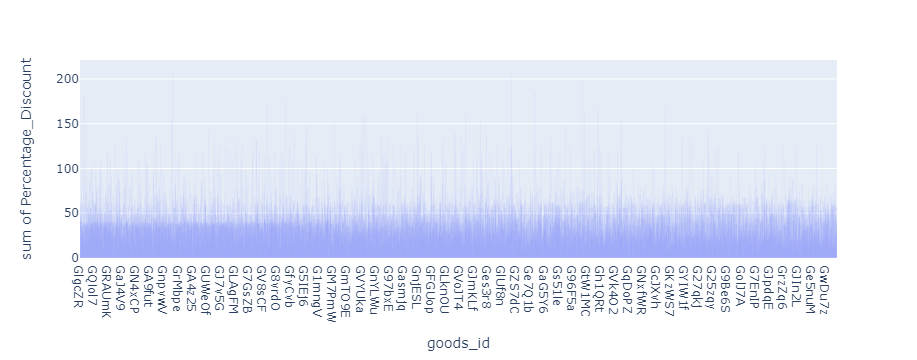

In [94]:
dfg = promo_sample.groupby(['Percentage_Discount']).head(20).reset_index()
fig = px.histogram(dfg, x='goods_id', y = 'Percentage_Discount')
fig.show()

### Top 10 Goods with their shop price and promote price

<AxesSubplot:xlabel='goods_id'>

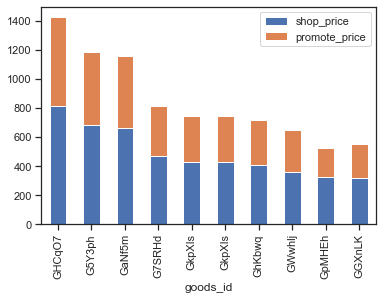

In [95]:
promo_sample.nlargest(columns="shop_price", n=10).plot(kind="bar",x="goods_id",y=["shop_price", "promote_price"], stacked=True)

### How many time a good come on promotion?

In [72]:
promo_sample['goods_id'].value_counts()

Gy4Az9    3
GmEQyK    3
GBaIu3    3
Gg2nqM    3
G3SxbI    3
         ..
GFhQn6    1
GH1fAB    1
GJQ0RI    1
GVhNlB    1
GYDWem    1
Name: goods_id, Length: 16259, dtype: int64

### Top 10 frequently goods on promotion

Text(0.5, 1.0, 'Frequent Promotion Goods')

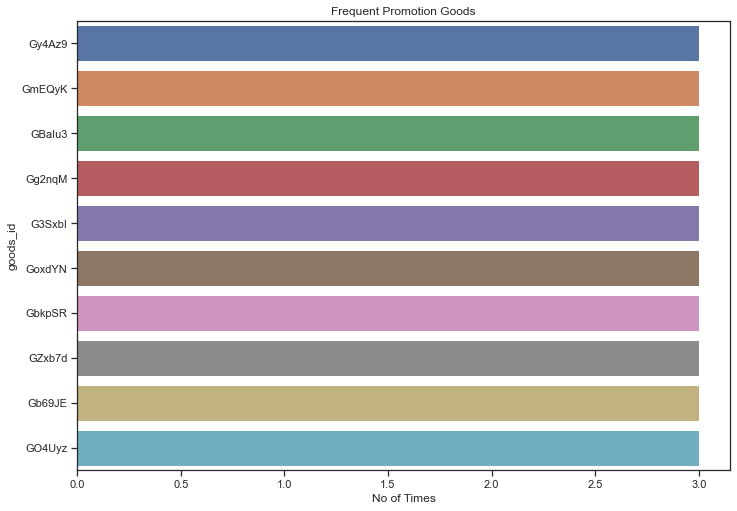

In [75]:
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(data=promo_sample, order=promo_sample.goods_id.value_counts().nlargest(10).index, y='goods_id')
ax.set(xlabel='No of Times', ylabel='goods_id')
ax.set_title('Frequent Promotion Goods')

In [ ]:
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.countplot(data=i_data, order=i_data.Pick_locationId.value_counts().nlargest(10).index, y='Pick_locationId')
ax.set(xlabel='Maximum Picks', ylabel='Pickup_Location')
ax.set_title('Top Pickup Locations')

# SKU Relation
 It shows only sku and good_id of the products. For every item sku is unique but all the same items have same good_id.

In [22]:
%%time
sku_relation=dd.read_csv("data/goods_sku_relation.csv")

Wall time: 40.9 ms


In [11]:
sku_relation.compute().shape

(3245170, 2)

In [12]:
sku_relation.dtypes

sku_id      object
goods_id    object
dtype: object

In [13]:
sku_relation.head()

,sku_id,goods_id
0,SKi4vm9R,Gd4qzR
1,SKoqfFbc,GKokDh
2,SKYR0sAQ,GlOIaX
3,SK78Nimt,GJYEoa
4,SKP3CRsW,GJYEoa


In [13]:
#goods_id = sku_relation.groupby('goods_id')['sku_id'].nunique()

In [14]:
a=sku_relation.describe(include=['object', 'category']).compute()

In [15]:
a.head()

,sku_id,goods_id
unique,3245170,423453
count,3245170,3245170
top,SK012CKt,GAnJO3
freq,1,266


# Goods Sale

- Shows sales of goods
- Which goods have high demand?
- Monthly Sales


In [77]:
%%time
goodsale=dd.read_csv("data/goodsale.csv", dtype='unicode')

Wall time: 49.9 ms


In [62]:
goodsale.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 8 entries, data_date to month_yr
dtypes: datetime64[ns](1), object(6), int64(1)

In [78]:
goodsale["data_date"] = dd.to_datetime(goodsale.data_date)

In [79]:
goodsale.compute().shape

(7325028, 6)

In [80]:
goodsale=goodsale.sort_values(by='data_date').reset_index()

In [20]:
goodsale.head(3)

,index,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price
0,672964,2017-03-01,G19epx,SK2qWCMu,1,2.99,2.99
1,1381626,2017-03-01,GiPNbr,SKFsCaU7,1,3.99,11.99
2,323345,2017-03-01,GNFSke,SKiFQx2N,1,17.99,25.99


In [ ]:
#goodsale = goodsale.drop('level_0', axis=1)

In [81]:
goodsale = goodsale.drop('index', axis=1)

In [82]:
goodsale.columns

Index(['data_date', 'goods_id', 'sku_id', 'goods_num', 'goods_price',
       'orginal_shop_price'],
      dtype='object')

## High Demanding Goods
 - High demanding goods are on top
 - We can also see 195,498 kinds of goods sold but in dataset it is mentioned above 423453 goods.

In [99]:
Top_goodsale=goodsale['goods_id'].compute().value_counts()

#### Top 10 High Demanding Goods 

In [100]:
Top_10_goods=Top_goodsale.head(10)

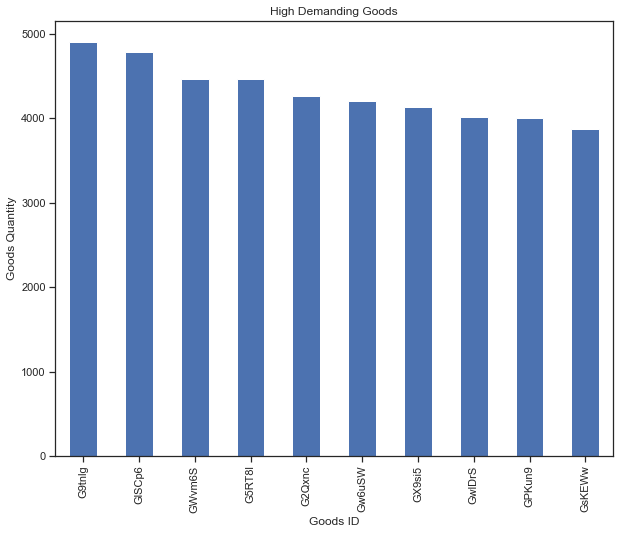

In [102]:
Top_10_goods.plot(kind='bar', figsize=(10,8))
plt.title('High Demanding Goods')
plt.xlabel('Goods ID')
plt.ylabel('Goods Quantity')
plt.show()

In [31]:
goodsale['month'] = goodsale['data_date'].dt.month

In [55]:
goodsale.head(3)

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,month,month_yr
0,2017-03-01,GLW9ER,SKFqzN2o,2,9.99,11.99,3,03-2017
1,2017-03-01,GuyNEv,SKdYn4bo,2,12.99,17.99,3,03-2017
2,2017-03-01,GcnaE7,SKidVCIw,1,4.99,4.99,3,03-2017


#### Add Month column to show monthly sale

### Month column
- month column is added to show monthly sale.

In [82]:
goodsale['month_yr'] = goodsale['data_date'].apply(lambda x: x.strftime('%m-%Y'))

C:\Users\admin\anaconda3\lib\site-packages\dask\dataframe\core.py:3519: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('data_date', 'object'))

  warnings.warn(meta_warning(meta))


In [ ]:
# try to change datatype of columns because dtype is object and data is in numeric form. But it throws error.

In [ ]:
goodsale[['goods_num', 'goods_price', 'orginal_shop_price']] = goodsale[['goods_num', 'goods_price', 'orginal_shop_price']].apply(pd.to_numeric, axis=1)

In [58]:
monthly_sale=goodsale.groupby('month_yr')['orginal_shop_price'].sum()

In [59]:
monthly_sale.head()

month_yr
03-2017    6.997.9916.9928.995.9929.996.9917.9913.998.991...
04-2017    17.9926.993.999.995.9921.995.9927.995.998.997....
05-2017    10.9911.9964.0031.9921.993.9935.9923.9929.9914...
06-2017    6.999.9912.9943.9914.9926.998.9923.9924.9916.9...
07-2017    16.997.996.995.9910.9954.0011.9911.991.9913.99...
Name: orginal_shop_price, dtype: object

# Sale of Goods Sample Data 
- select sample data for further work.
- Because it is about 275 MB data with 7325028 rows

In [87]:
%%time
sale_sample=goodsale.sample(frac=0.01).compute() 

Wall time: 2min 13s


In [88]:
sale_sample.head()

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price,month_yr
1574517,2017-10-12,G4PWck,SK8kCoQp,1,17.99,26.99,10-2017
1624050,2017-11-17,GjUXwe,SKgho9vu,1,3.99,7.99,11-2017
1515832,2017-11-21,GuUpF2,SK0vupkA,1,9.99,16.99,11-2017
293588,2017-10-31,GB2ZG5,SKu3pQvn,1,7.99,17.99,10-2017
781570,2017-06-09,GiL5bo,SK2ioBaA,1,11.99,15.99,06-2017


### Try to show the relation that which goods are more sale in which month through scatter plot

<AxesSubplot:xlabel='month_yr', ylabel='goods_id'>

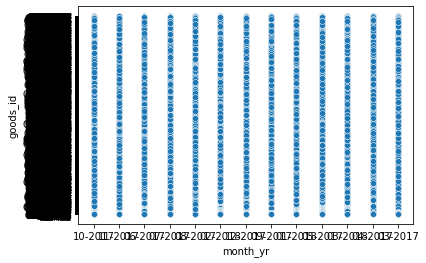

In [109]:
sns.scatterplot(data=sale_sample, x='month_yr', y='goods_id')

In [89]:
sale_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73249 entries, 1574517 to 391043
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_date           73249 non-null  datetime64[ns]
 1   goods_id            73249 non-null  object        
 2   sku_id              73249 non-null  object        
 3   goods_num           73249 non-null  object        
 4   goods_price         73249 non-null  object        
 5   orginal_shop_price  73249 non-null  object        
 6   month_yr            73249 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 4.5+ MB


In [90]:
sale_sample[['goods_num', 'goods_price', 'orginal_shop_price']] = sale_sample[['goods_num', 'goods_price', 'orginal_shop_price']].apply(pd.to_numeric)

In [91]:
sale_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73249 entries, 1574517 to 391043
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   data_date           73249 non-null  datetime64[ns]
 1   goods_id            73249 non-null  object        
 2   sku_id              73249 non-null  object        
 3   goods_num           73249 non-null  int64         
 4   goods_price         73249 non-null  float64       
 5   orginal_shop_price  73249 non-null  float64       
 6   month_yr            73249 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 4.5+ MB


### Monthly sale displayed

In [92]:
monthly_sale_sample = sale_sample.groupby('month_yr')['orginal_shop_price'].sum()

In [93]:
monthly_sale_sample

month_yr
01-2018    107080.60
02-2018     87309.14
03-2017     74397.25
03-2018     53142.60
04-2017     89221.03
05-2017    109271.71
06-2017    109053.70
07-2017     89309.03
08-2017    112703.61
09-2017     96400.68
10-2017    122922.33
11-2017    243525.67
12-2017    169221.37
Name: orginal_shop_price, dtype: float64

### Interactive Visualization for Monthly Sales by using plotly express

In [99]:
px.bar(sale_sample,
      x = sale_sample.groupby("month_yr")["orginal_shop_price"].sum().index,
      y = sale_sample.groupby("month_yr")["orginal_shop_price"].sum(),
      title = " Monthly sales")

#### Using matplotlib, visualize the monthly sale

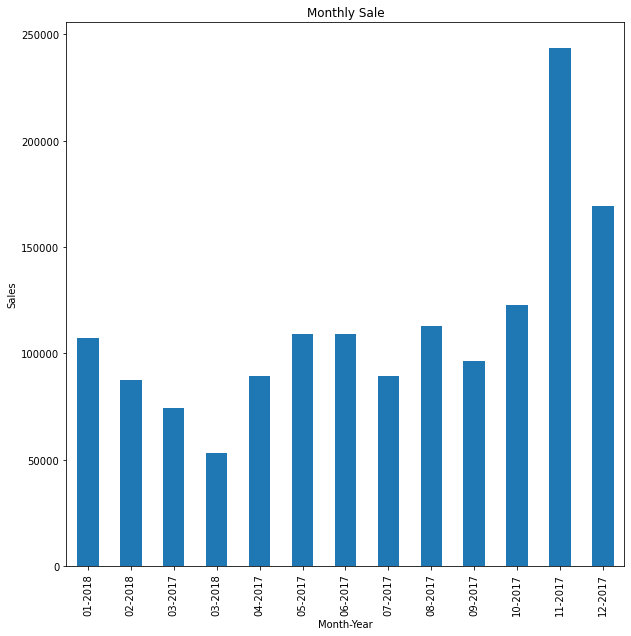

In [107]:
monthly_sale_sample.plot(kind= 'bar', figsize=(10,10), grid=False)
plt.title('Monthly Sale')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.show()

sns.histplot(sale_sample

# Goods daily
It shows day-day data. Means how many times in a day a specific good sale, how many times user click on that goods, add in the cart and include in the favourites.

In [106]:
%%time
goodsdaily=dd.read_csv("data/goodsdaily.csv",  dtype='unicode')

Wall time: 48.4 ms


In [107]:
goodsdaily["data_date"]=dd.to_datetime(goodsdaily.data_date)

In [43]:
goodsdaily.compute().shape

(35201588, 7)

In [99]:
goodsdaily.head()

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,2017-08-23,G8OeZY,72,2,3,0,6
1,2017-08-23,Gjytr2,96,0,1,0,336
2,2017-08-23,GR0SgC,15,0,0,0,98
3,2017-08-23,GMkqxN,9,0,0,0,13
4,2017-08-23,GuRXYe,538,5,9,2,69


#### Sampling goods daily
- It is more than 1GB data with 35201588 rows.

In [108]:
%%time
goodsdaily_sample= goodsdaily.sample(frac= 0.009).compute()

Wall time: 1min 4s


In [109]:
goodsdaily_sample.shape

(316816, 7)

In [111]:
goodsdaily_sample.compute().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35201588 entries, 0 to 227356
Data columns (total 7 columns):
 #   Column           Dtype         
---  ------           -----         
 0   data_date        datetime64[ns]
 1   goods_id         object        
 2   goods_click      object        
 3   cart_click       object        
 4   favorites_click  object        
 5   sales_uv         object        
 6   onsale_days      object        
dtypes: datetime64[ns](1), object(6)
memory usage: 2.1+ GB


In [112]:
goodsdaily_sample[['goods_click', 'cart_click', 'favorites_click', 'sales_uv', 'onsale_days']] = goodsdaily_sample[['goods_click', 'cart_click', 'favorites_click', 'sales_uv', 'onsale_days']].apply(pd.to_numeric, axis=1)

### Relation between goods-click and goods-sale

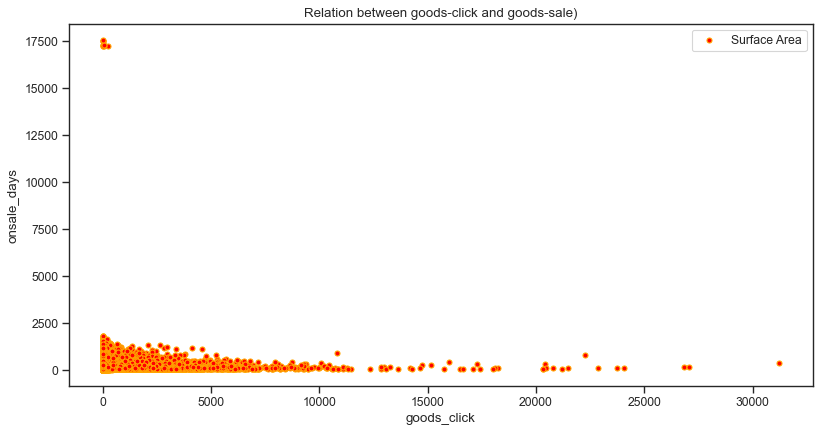

In [114]:
plt.figure(figsize=(12, 6), dpi=80)
plt.scatter(goodsdaily_sample['goods_click'],goodsdaily_sample['onsale_days'], s=20, edgecolor="orange", c="red", label="Surface Area")
plt.xlabel("goods_click")
plt.ylabel("onsale_days")
plt.title("Relation between goods-click and goods-sale)")
plt.legend()
plt.show()

# Goods Info

It has information about the goods.

In [44]:
%%time
goodsinfo=dd.read_csv("data/goodsinfo.csv")

CPU times: user 62.5 ms, sys: 15.6 ms, total: 78.1 ms
Wall time: 115 ms


In [45]:
%%time
goodsinfo.compute().shape

CPU times: user 391 ms, sys: 188 ms, total: 578 ms
Wall time: 654 ms


(423452, 10)

In [46]:
goodsinfo.head()

,goods_id,cat_level1_id,cat_level2_id,cat_level3_id,cat_level4_id,cat_level5_id,cat_level6_id,cat_level7_id,goods_season,brand_id
0,GBLrYn,2,6,-1,-1,-1,-1,-1,0,0
1,G2OzvE,35,36,-1,-1,-1,-1,-1,6,74
2,GIa1pG,2,6500,4798,-1,-1,-1,-1,0,55
3,GR7cM4,31,50,-1,-1,-1,-1,-1,0,0
4,GRQgu3,2,6500,4798,-1,-1,-1,-1,2,31
